In [63]:
%matplotlib inline
import geopandas
from shapely.geometry import Point
import missingno as msn
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from tqdm import tqdm
from IPython.display import display
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.compose import TransformedTargetRegressor
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot, AlphaSelection, PredictionError
from sklearn.metrics import median_absolute_error


In [2]:
df=pd.read_csv("csv file location")

In [3]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [4]:
df.dtypes

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

In [5]:
for i in ['floor','animal','furniture']:
    print(df[i].value_counts())
    print('\n')

-      2461
1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
301       1
51        1
46        1
35        1
Name: floor, dtype: int64


acept        8316
not acept    2376
Name: animal, dtype: int64


not furnished    8086
furnished        2606
Name: furniture, dtype: int64




In [6]:
df['floor'] = df['floor'].replace('-','0')
df['floor']= df['floor'].fillna(df['floor'].median()).astype('int')

In [7]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_app_train_data  = pd.concat([total, percent],axis=1, keys=['Total', 'Percent'])
missing_app_train_data.head(15)

,Total,Percent
total (R$),0,0.0
fire insurance (R$),0,0.0
property tax (R$),0,0.0
rent amount (R$),0,0.0
hoa (R$),0,0.0
furniture,0,0.0
animal,0,0.0
floor,0,0.0
parking spaces,0,0.0
bathroom,0,0.0


In [8]:
df.drop(['total (R$)'],axis=1,inplace=True)

# EDA

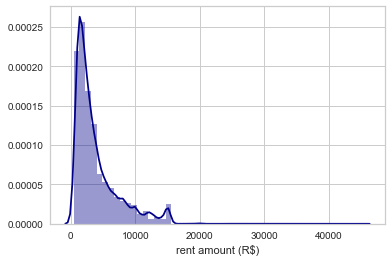

In [9]:
sns.distplot(df['rent amount (R$)'],color="darkblue")
plt.show()

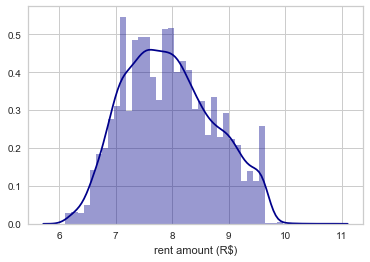

In [10]:
sns.distplot(np.log(df['rent amount (R$)']),color="darkblue")
plt.show()

When we transform Y to log, values become more comparable and we reduce the relative importance of tail observations

In [11]:
pd.options.display.float_format = '{:.4f}'.format
df.describe()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
count,10692.0000,10692.0000,10692.0000,10692.0000,10692.0000,10692.0000,10692.0000,10692.0000,10692.0000
mean,149.2179,2.5061,2.2368,1.6091,5.0680,1174.0217,3896.2472,366.7044,53.3009
std,537.0169,1.1713,1.4072,1.5895,6.0691,15592.3052,3408.5455,3107.8323,47.7680
min,11.0000,1.0000,1.0000,0.0000,0.0000,0.0000,450.0000,0.0000,3.0000
25%,56.0000,2.0000,1.0000,0.0000,1.0000,170.0000,1530.0000,38.0000,21.0000
50%,90.0000,2.0000,2.0000,1.0000,3.0000,560.0000,2661.0000,125.0000,36.0000
75%,182.0000,3.0000,3.0000,2.0000,8.0000,1237.5000,5000.0000,375.0000,68.0000
max,46335.0000,13.0000,10.0000,12.0000,301.0000,1117000.0000,45000.0000,313700.0000,677.0000


## Let's examine the sample data points related to the maximum value of some variables as these could be outliers

In [12]:
for i in df.describe().columns:
    print(i)
    display(df.nlargest(10, i))
    print('\n')

area


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,960,8500,646,114
5915,São Paulo,24606,5,4,4,12,acept,not furnished,2254,8100,7859,103
9241,Campinas,12732,3,2,0,3,acept,not furnished,700,1600,96,21
5129,Belo Horizonte,2000,4,2,3,0,acept,not furnished,0,4956,200,82
8790,Belo Horizonte,2000,3,3,2,2,acept,furnished,3000,5000,200,67
654,São Paulo,1600,6,6,6,0,acept,furnished,0,7600,1834,115
4813,São Paulo,1600,4,5,12,0,acept,not furnished,1,6900,5000,104
3559,São Paulo,1100,4,6,10,0,acept,not furnished,3000,14000,2000,211
2423,Belo Horizonte,1020,5,4,6,0,acept,furnished,0,6520,654,107
640,Belo Horizonte,1000,5,7,8,0,acept,not furnished,0,14980,1904,246




rooms


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
7835,Rio de Janeiro,439,13,4,3,0,acept,not furnished,0,15000,667,229
752,Belo Horizonte,341,10,6,7,0,acept,not furnished,0,5500,459,91
1639,São Paulo,400,10,5,8,0,acept,not furnished,0,10900,1417,164
5178,São Paulo,400,10,9,8,0,acept,not furnished,0,8330,550,126
9565,São Paulo,400,9,4,4,0,acept,not furnished,100,12000,500,181
169,São Paulo,320,8,4,0,0,acept,not furnished,450,10500,350,158
456,São Paulo,450,8,5,5,0,acept,not furnished,0,8000,1000,121
3792,Belo Horizonte,800,8,7,4,0,acept,not furnished,0,14000,834,230
5660,Belo Horizonte,300,8,3,1,0,acept,not furnished,0,4000,500,66
6073,São Paulo,340,8,5,4,0,acept,not furnished,0,7000,1400,106




bathroom


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
2055,São Paulo,998,7,10,4,0,acept,furnished,0,15000,5000,226
8187,São Paulo,700,4,10,0,0,acept,not furnished,0,15000,8750,226
9021,Belo Horizonte,458,8,10,4,0,acept,not furnished,0,7000,419,115
421,São Paulo,900,4,9,8,1,acept,not furnished,0,15000,5700,226
1020,São Paulo,845,5,9,6,0,acept,furnished,0,8499,1000,128
1130,São Paulo,360,4,9,8,0,acept,not furnished,0,8540,1329,129
5178,São Paulo,400,10,9,8,0,acept,not furnished,0,8330,550,126
1893,Porto Alegre,540,6,8,3,0,acept,not furnished,0,15000,467,267
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,960,8500,646,114
2511,São Paulo,700,6,8,8,0,acept,furnished,0,14000,1020,211




parking spaces


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
4813,São Paulo,1600,4,5,12,0,acept,not furnished,1,6900,5000,104
3559,São Paulo,1100,4,6,10,0,acept,not furnished,3000,14000,2000,211
5445,São Paulo,190,1,2,10,0,acept,not furnished,0,3900,34,59
131,São Paulo,900,4,6,8,0,acept,not furnished,0,15000,4417,226
143,Campinas,999,5,7,8,0,acept,not furnished,0,14000,667,211
176,São Paulo,500,4,5,8,0,acept,not furnished,0,15000,1850,226
317,São Paulo,450,4,3,8,0,acept,not furnished,0,14000,175,211
421,São Paulo,900,4,9,8,1,acept,not furnished,0,15000,5700,226
510,Belo Horizonte,417,3,5,8,0,acept,not furnished,0,7650,450,126
570,Belo Horizonte,680,7,6,8,0,acept,not furnished,0,8000,428,132




floor


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
2562,Belo Horizonte,80,3,2,2,301,acept,not furnished,750,2600,164,35
5694,Campinas,64,2,2,2,51,acept,not furnished,800,1900,129,25
1654,São Paulo,353,4,5,5,46,acept,not furnished,3000,10000,0,127
671,São Paulo,250,3,2,3,35,acept,furnished,2500,15000,1084,191
6096,São Paulo,84,2,3,2,32,not acept,furnished,850,8500,450,108
10179,São Paulo,51,1,1,0,32,not acept,not furnished,429,3250,37,42
2522,São Paulo,77,1,2,1,29,acept,furnished,750,7740,209,99
2709,São Paulo,105,1,1,2,29,not acept,not furnished,1300,8700,417,111
4389,São Paulo,292,4,4,4,29,acept,not furnished,1700,5000,686,64
5528,Belo Horizonte,305,4,5,5,29,acept,not furnished,4596,14000,2239,187




hoa (R$)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
255,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38
6979,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38
6230,São Paulo,340,5,4,2,7,acept,not furnished,220000,12000,1000,153
2859,São Paulo,285,4,5,4,6,acept,furnished,200000,20000,1834,254
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900,58
1444,Porto Alegre,42,1,1,0,10,acept,not furnished,32000,700,40,11
1213,São Paulo,850,6,7,4,0,not acept,not furnished,15000,13000,2465,196
415,São Paulo,488,4,3,3,0,acept,not furnished,14130,6400,1214,82
5293,São Paulo,850,5,7,8,1,not acept,not furnished,14000,4000,0,51
974,São Paulo,600,6,7,4,0,acept,furnished,10000,15000,84,226




rent amount (R$)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
2182,São Paulo,700,4,7,8,0,acept,not furnished,0,45000,8750,677
7748,São Paulo,350,3,3,3,0,acept,not furnished,0,30000,560,451
6947,São Paulo,486,8,4,6,0,acept,not furnished,0,25000,2200,376
2619,São Paulo,80,2,1,1,1,acept,not furnished,875,24000,0,305
157,São Paulo,660,4,5,5,12,acept,furnished,4800,20000,1750,254
1253,São Paulo,315,3,5,2,14,not acept,not furnished,4300,20000,959,254
1743,São Paulo,410,4,5,5,1,acept,not furnished,0,20000,0,254
2859,São Paulo,285,4,5,4,6,acept,furnished,200000,20000,1834,254
5525,São Paulo,900,3,4,8,0,acept,not furnished,0,20000,3813,301
6185,São Paulo,455,4,5,4,5,acept,not furnished,8500,19500,3334,248




property tax (R$)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
6645,São Paulo,42,1,2,1,6,not acept,not furnished,690,2500,313700,32
6243,Rio de Janeiro,95,2,2,1,11,acept,not furnished,1024,3000,28120,39
1699,São Paulo,700,4,4,4,0,acept,not furnished,0,10000,21880,151
10172,Belo Horizonte,260,4,4,6,10,acept,furnished,3200,11900,12500,159
5331,São Paulo,300,4,5,5,6,not acept,not furnished,3500,1990,10830,26
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900,58
19,São Paulo,600,4,5,6,0,acept,not furnished,0,12000,9500,181
7674,São Paulo,890,5,6,8,0,not acept,not furnished,0,11000,9500,166
2182,São Paulo,700,4,7,8,0,acept,not furnished,0,45000,8750,677
8187,São Paulo,700,4,10,0,0,acept,not furnished,0,15000,8750,226




fire insurance (R$)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
2182,São Paulo,700,4,7,8,0,acept,not furnished,0,45000,8750,677
7748,São Paulo,350,3,3,3,0,acept,not furnished,0,30000,560,451
6947,São Paulo,486,8,4,6,0,acept,not furnished,0,25000,2200,376
2521,Porto Alegre,318,4,3,0,0,acept,not furnished,0,19000,384,338
2619,São Paulo,80,2,1,1,1,acept,not furnished,875,24000,0,305
5525,São Paulo,900,3,4,8,0,acept,not furnished,0,20000,3813,301
1893,Porto Alegre,540,6,8,3,0,acept,not furnished,0,15000,467,267
2901,Porto Alegre,425,4,4,0,0,acept,not furnished,0,15000,750,267
6726,Porto Alegre,200,4,3,0,0,not acept,not furnished,0,15000,834,267
10416,Porto Alegre,350,3,3,3,0,acept,not furnished,0,15000,667,267


## Removing outliers based on Z-score

In [13]:
z = np.abs(stats.zscore(df.select_dtypes('int')))
print(z)

[[0.14752165 0.432099   0.87895963 ... 0.17493534 0.05010297 0.23658936]
 [0.31803478 1.27553453 1.25303592 ... 0.31209868 0.44512065 0.20305577]
 [0.12889939 1.28591577 0.87895963 ... 0.32163234 0.11799913 0.25752484]
 ...
 [0.14752165 0.42171777 0.54237074 ... 0.61722843 0.01116726 0.51708801]
 [0.05441036 0.432099   0.16829445 ... 2.37759236 0.02822175 2.12912015]
 [0.12889939 0.432099   0.87895963 ... 0.73238392 0.06490498 0.655299  ]]


In [14]:
df = df[(z < 3).all(axis=1)]

In [15]:
def plot_dist(ele):
    sns.relplot(x="rent amount (R$)",y=ele,
                hue="city",
                palette="YlGnBu", sizes=(10, 125),
                edgecolor=".2", linewidth=.5, alpha=.75,
                data=df);
    

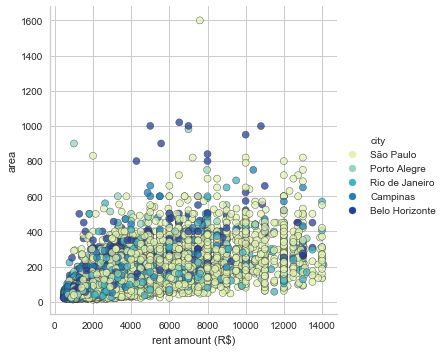

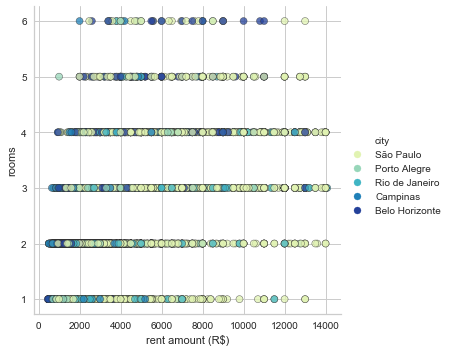

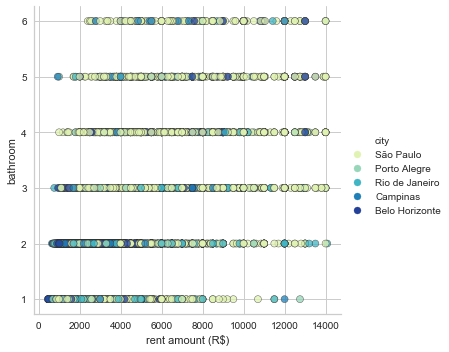

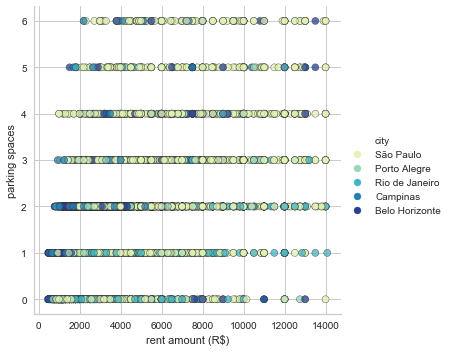

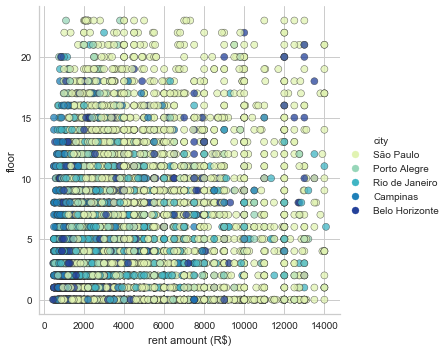

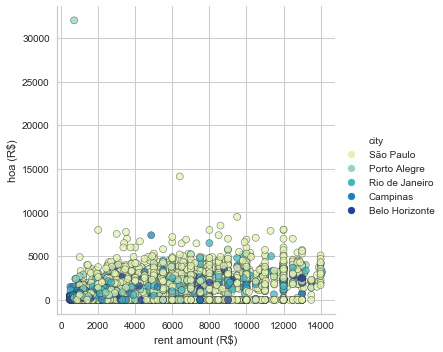

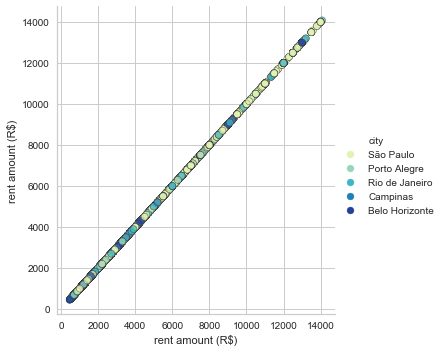

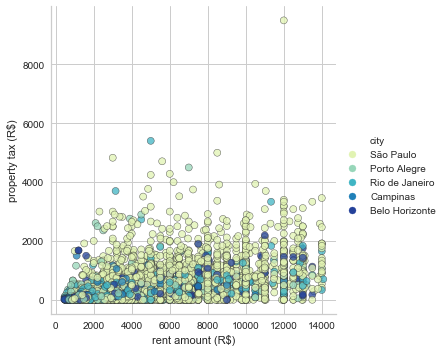

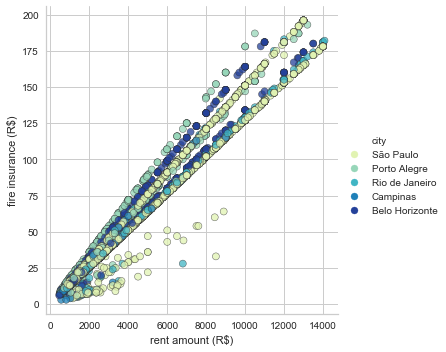

In [16]:
for i in df.describe().columns:
    plot_dist(i)

In [17]:
df.drop(df[df['hoa (R$)'] > 10000 ].index,inplace=True)
df.drop(df[df['property tax (R$)'] > 6000 ].index,inplace=True)
df.drop(df[df['area'] > 1200 ].index,inplace=True)

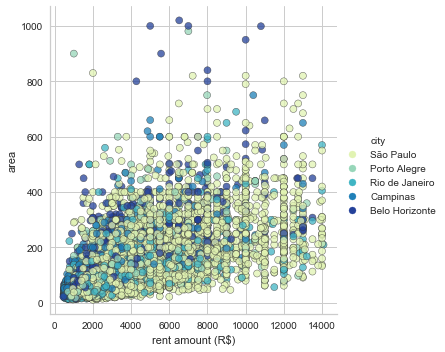

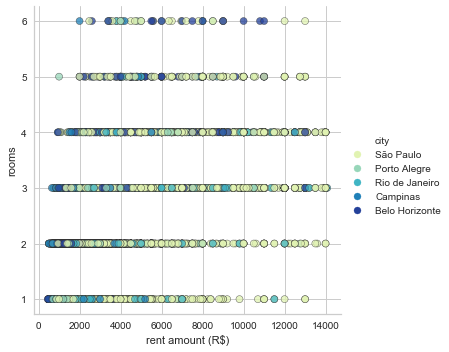

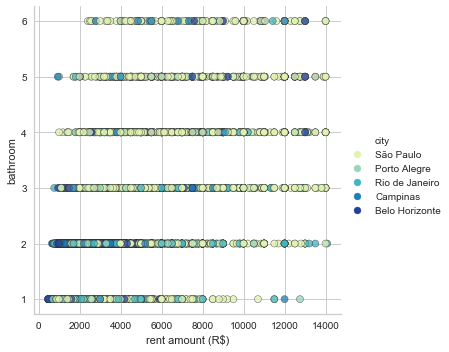

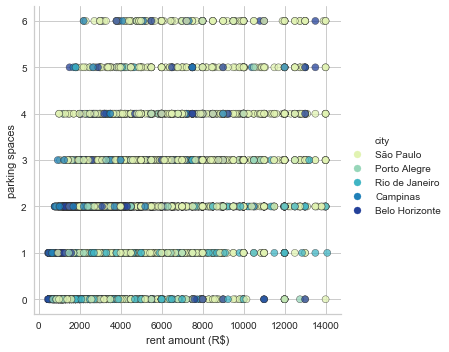

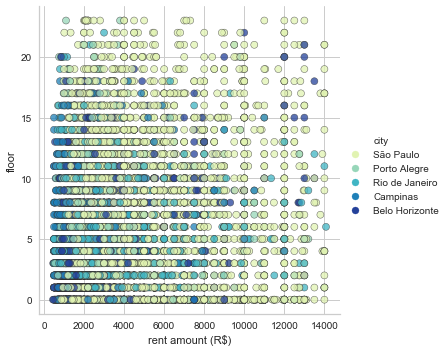

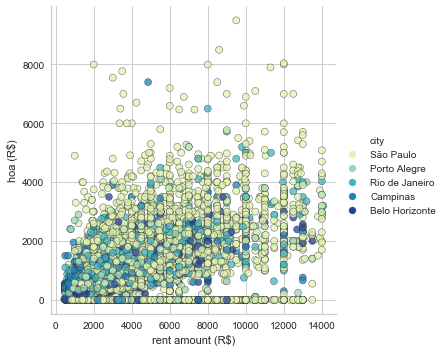

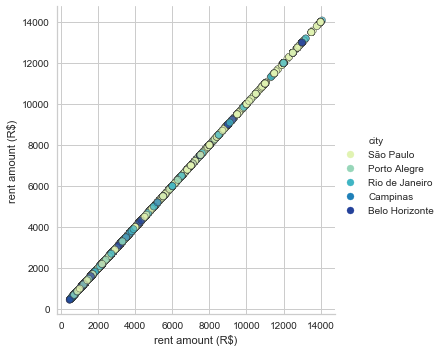

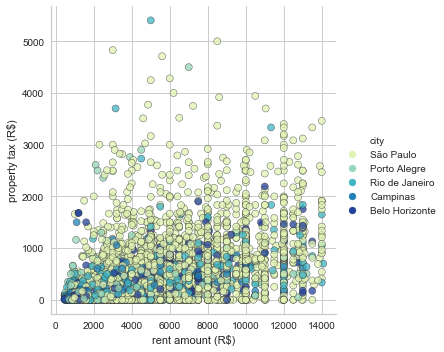

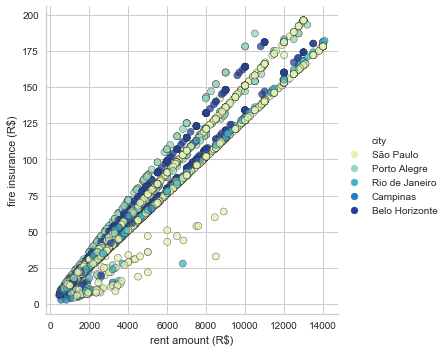

In [18]:
for i in df.describe().columns:
    plot_dist(i)

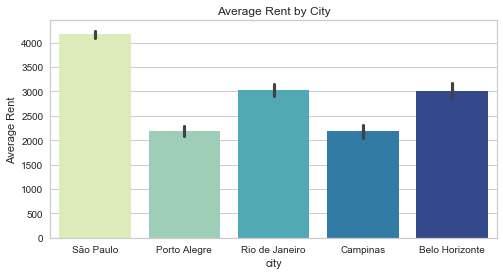

In [19]:
plt.figure(figsize = (8,4))
sns.barplot(data = df, x='city', y='rent amount (R$)', estimator=np.mean, palette = "YlGnBu")
plt.ylabel('Average Rent')
plt.title('Average Rent by City')
plt.show()

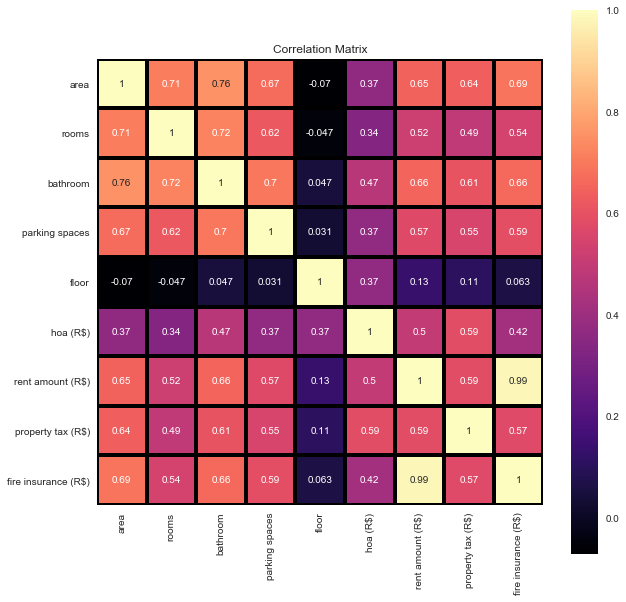

In [20]:
df_correlations=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_correlations, vmax=1, square=True,annot=True,cmap='magma',linewidths=3, linecolor='black')


plt.title('Correlation Matrix')
plt.show()

In [21]:
df.drop(['fire insurance (R$)'],axis=1,inplace=True)

In [22]:
la = LabelEncoder()
df['animal'] = la.fit_transform(df['animal'])
df['furniture'] =la.fit_transform(df['furniture'])

In [23]:
df=pd.get_dummies(df)

In [24]:
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import train_test_split

X=df.drop(['rent amount (R$)'],axis=1)
y=np.log(df['rent amount (R$)'].values.ravel())


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=4)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)
print(y.shape)

(8062, 14)
(2016, 14)
(10078, 14)
(10078,)


In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test= pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [41]:
def plot_feature_importances(df):
    #sns.set_style("whitegrid")
    df = df.sort_values('importance', ascending = False).reset_index()  
    df['importance_normalized'] = df['importance'] / df['importance'].sum()  
    plt.figure(figsize = (10, 6))
    ax = plt.subplot() 
    ax.barh(list(reversed(list(df.index[:8]))), 
            df['importance_normalized'].head(8), 
            align = 'center',color='black')
    ax.set_yticks(list(reversed(list(df.index[:8]))))
    ax.set_yticklabels(df['feature'].head(8))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.grid(b=None)
    plt.show()
    
    return df

# OLS

In [42]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Training R-Squared: ",+regr.score(X_train,y_train))
print("Test R-Squared: ",+regr.score(X_test,y_test))
print("Median Absolute Error",+median_absolute_error(y_test, y_pred))

Training R-Squared:  0.6386456407273122
Test R-Squared:  0.6241930748728932
Median Absolute Error 0.28710522099536284


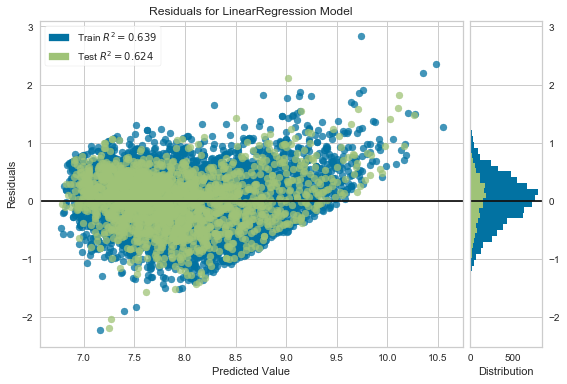

In [43]:
mpl.rcParams['figure.figsize'] = (9,6)

visualizer = ResidualsPlot(regr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show();

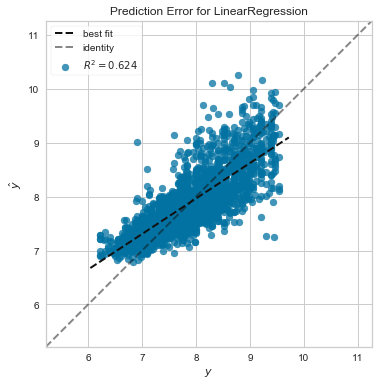

In [44]:
visualizer = PredictionError(regr)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)   
visualizer.show();

# Random Forest

In [81]:
rf = RandomForestRegressor(random_state=0,n_estimators=100,max_depth=10)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
print("Training R-Squared: ",+rf.score(X_train,y_train)) 
print("Test R-Squared: ",+rf.score(X_test,y_test)) 
print("Median Absolute Error",+median_absolute_error(y_test, y_pred))

Training R-Squared:  0.8513522710114527
Test R-Squared:  0.7316661252270751
Median Absolute Error 0.2263935726738242


In [82]:
param_grid = {
    'max_depth': [5, 10,12,15],
    'max_features': [2, 3, 5, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 150]
}

rf = RandomForestRegressor(random_state=0)
grf= GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='r2')

grf.fit(X_train, y_train)
rf_best = grf.best_estimator_
grf.best_score_

0.748533179936463

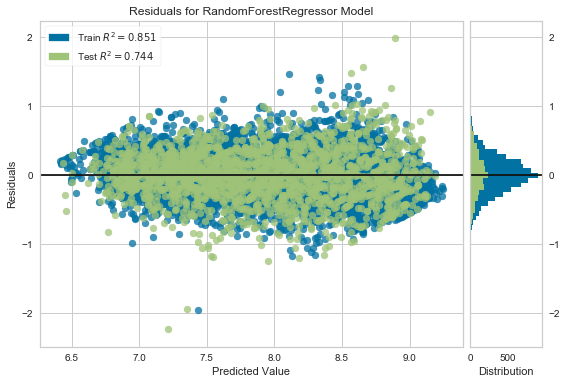

In [85]:
mpl.rcParams['figure.figsize'] = (9,6)

visualizer = ResidualsPlot(rf_best)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show();

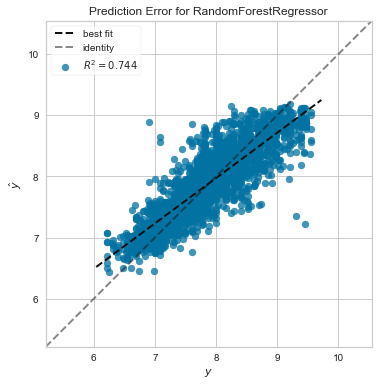

In [86]:
visualizer = PredictionError(rf_best)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)   
visualizer.show();

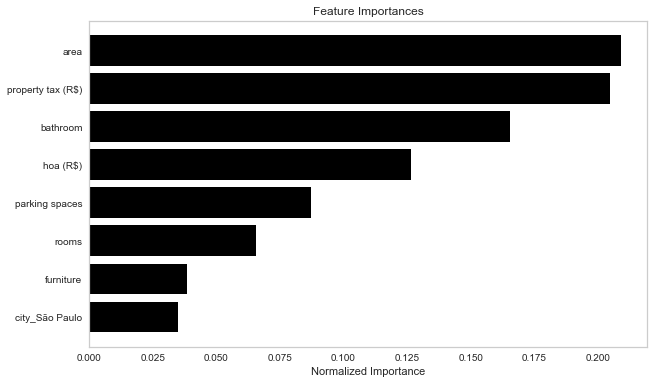

In [89]:
features = list(X.columns)
feature_importance_values = rf_best.feature_importances_
feature_importances = pd.DataFrame({'feature': features,'importance': feature_importance_values})
feature_importances_sorted = plot_feature_importances(feature_importances).sort_values("importance",ascending=False)

# GBM regressor

In [49]:
GBM = GradientBoostingRegressor(random_state=0,n_estimators=100)
GBM.fit(X_train, y_train)
y_pred=GBM.predict(X_test)
print("Training R-Squared: ",+GBM.score(X_train,y_train)) 
print("Test R-Squared: ",+GBM.score(X_test,y_test))
print("Median Absolute Error",+median_absolute_error(y_test, y_pred))

Training R-Squared:  0.7566511531830868
Test R-Squared:  0.7199417098746914
Median Absolute Error 0.24206556328440776


In [90]:
param_grid = {
    'max_depth': [5, 10,12,15],
    'max_features': [2, 3, 5, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 150]
}

GBM = GradientBoostingRegressor(random_state=0)
rgbm= GridSearchCV(estimator = GBM, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, scoring='r2')

rgbm.fit(X_train, y_train)
gbm_best = rgbm.best_estimator_
rgbm.best_score_

0.7496426179463812

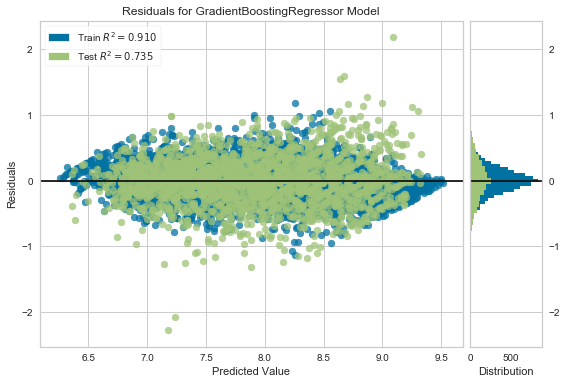

In [91]:
mpl.rcParams['figure.figsize'] = (9,6)

visualizer = ResidualsPlot(gbm_best)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show();

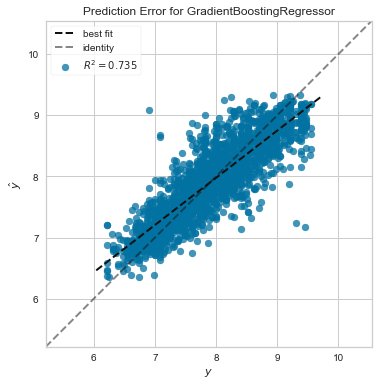

In [92]:
visualizer = PredictionError(gbm_best)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)   
visualizer.show();

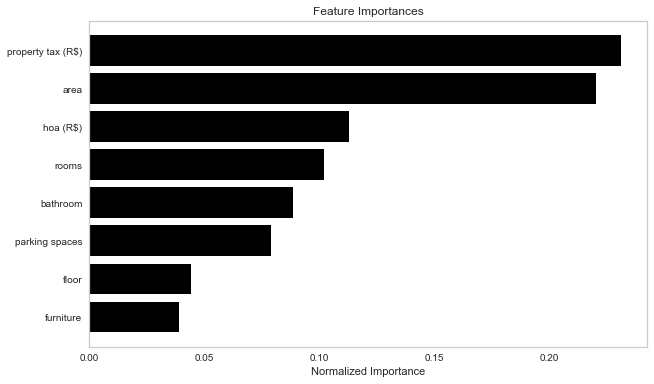

In [94]:
features = list(X.columns)
feature_importance_values = gbm_best.feature_importances_
feature_importances = pd.DataFrame({'feature': features,'importance': feature_importance_values})
feature_importances_sorted = plot_feature_importances(feature_importances).sort_values("importance",ascending=False)